## Imports

In [1]:
%matplotlib inline

from osgeo import osr, gdal

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import fiona

import re

sns.set(color_codes=True)

## Read location of Roads

In [2]:
datafile = '../data/roads/kolovai-tonga_planet_osm_line_lines.shp'

possible_tags = set()

coll_list = []

with fiona.drivers():
    with fiona.open(datafile) as source:
        for coll in source:
            print(coll)
            coll_list.append(coll)

possible_tags

{'type': 'Feature', 'id': '0', 'geometry': {'type': 'LineString', 'coordinates': [(-175.33982444635888, -21.10495236721501), (-175.3398235, -21.1049178), (-175.3398188, -21.1048445), (-175.3398053, -21.1046368), (-175.3397978, -21.1045646), (-175.339776, -21.1043561), (-175.339768, -21.104306), (-175.3397564, -21.1042342), (-175.3397214, -21.103941), (-175.3397154, -21.1038961), (-175.3396651, -21.1035112), (-175.3396577, -21.1034614), (-175.3396442, -21.1033853), (-175.3396268, -21.103287), (-175.3395877, -21.1030623), (-175.3395592, -21.102898), (-175.3395548, -21.1028728), (-175.3395306, -21.1027333), (-175.3394113, -21.1021326), (-175.3393717, -21.1018988), (-175.339338, -21.1016779), (-175.3393221, -21.1015735), (-175.3392926, -21.1012682), (-175.3393043, -21.1010574), (-175.3393126, -21.1009074), (-175.3393205, -21.1006938), (-175.3393387, -21.1004127), (-175.3393556, -21.1001522), (-175.3393576, -21.10004), (-175.3393578, -21.1000243), (-175.3393612, -21.0998348), (-175.3393664,

set()

## Reading Image

In [3]:
datafile = gdal.Open("../data/aerial_image/kolovai.tif")
bnd1 = datafile.GetRasterBand(1).ReadAsArray()
bnd2 = datafile.GetRasterBand(2).ReadAsArray()
bnd3 = datafile.GetRasterBand(3).ReadAsArray()
nx = datafile.RasterXSize # Raster xsize
ny = datafile.RasterYSize # Raster ysize

img = np.dstack((bnd1, bnd2, bnd3))

### Retrieve Latitude and Longitude of Image

In [4]:
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(datafile.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs.ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs, new_cs) 

#get the point to transform, pixel (0,0) in this case
W = datafile.RasterXSize
H = datafile.RasterYSize
gt = datafile.GetGeoTransform()
minx = gt[0]
miny = gt[3] + W*gt[4] + H*gt[5] 
maxx = gt[0] + W*gt[1] + H*gt[2]
maxy = gt[3]

#get the coordinates in lat long
xgeo0, ygeo0, _ = transform.TransformPoint(minx, miny)
xgeoN, ygeoN, _ = transform.TransformPoint(maxx, maxy)

In [5]:
print(xgeo0, ygeo0)
print(xgeoN, ygeoN)

-175.34907207131698 -21.104930856349313
-175.33536665317192 -21.08692801644621


## Process and Chunk

### Coordinate Converter and Image Chunker

In [6]:
class Converter:
    def __init__(self, geo0, geoN, img_shape):
        self.xgeo0, self.ygeo0 = geo0
        self.xgeoN, self.ygeoN = geoN
        self.H, self.W = img_shape
        print(img_shape)
    
    def geo_2_pixel(self, x, y):
        x_pix = ((x - self.xgeo0)/abs(self.xgeoN - self.xgeo0)) * self.W
        y_pix = ((y - self.ygeo0)/abs(self.ygeoN - self.ygeo0)) * self.H
        
        return int(round(x_pix)), int(round(y_pix))

class ImageChunker:
    def __init__(self, img, img_shape):
        self.img = img
        self.H, self.W = img_shape
    
    def chunk(self, x, y, d):
        if x < 0 or x > self.W or y < 0 or y > self.H:
            return (None, None)
        
        x_start = x - d
        
        if x_start < 0:
            d = x
            return self.chunk(x, y, d)
        
        x_end = x + d
        
        if x_end > self.W:
            d = self.W - x
            return self.chunk(x, y, d)
        
        y_start = y - d
        
        if y_start < 0:
            d = y
            return self.chunk(x, y, d)
        
        y_end = y + d
        
        if y_end > self.H:
            d = self.H - y
            return self.chunk(x, y, d)
        
        return (self.img[y_start: y_end, x_start: x_end], d)

In [8]:
from PIL import Image, ImageDraw

img_pil = Image.fromarray(img)

In [16]:
tmp = img_pil.crop((0, 0, 2000, 2000))
tmp.show()

img_pil.shape

AttributeError: 'Image' object has no attribute 'shape'

### Display Image Segment

In [7]:
def display_segment(loc_conv, handle_img, loc):
    x, y = loc_conv.geo_2_pixel(loc[0], loc[1])
    print(x,y)
    res = handle_image.chunk(x, y, 100)
    if res[0] is not None:
        print(res[1])
        fig = plt.figure(figsize=(10,10))
        plt.imshow(res[0])
        plt.show()
    else:
        print("Image Error!\n\n")

### Iterate and Display some Images

(25006, 17761)
719 3308
100


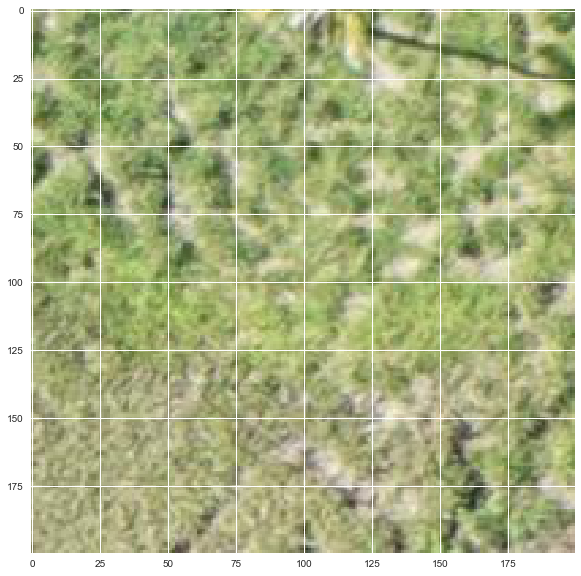

634 16060
100


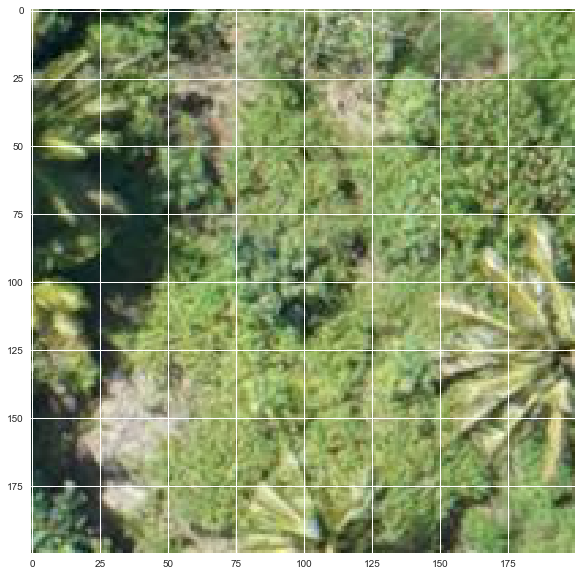

6122 8962
100


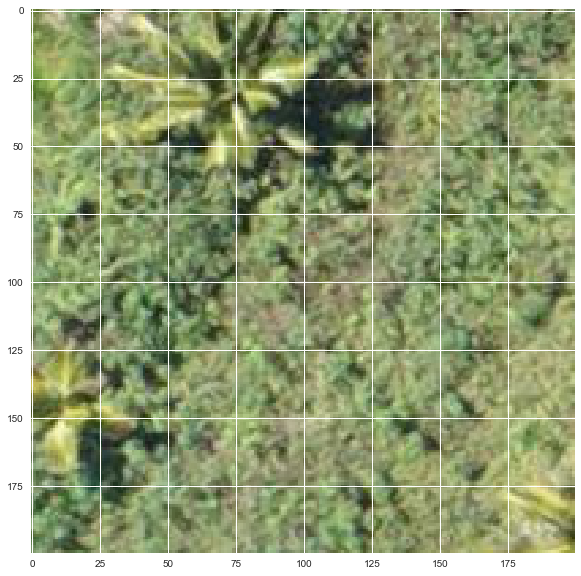

10337 14693
100


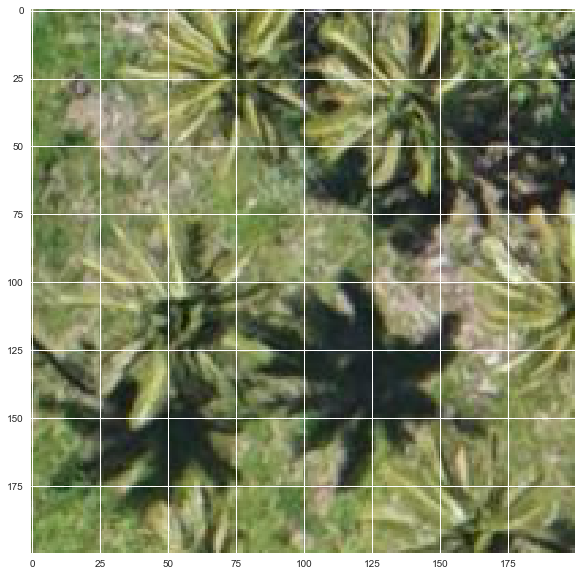

5380 20835
100


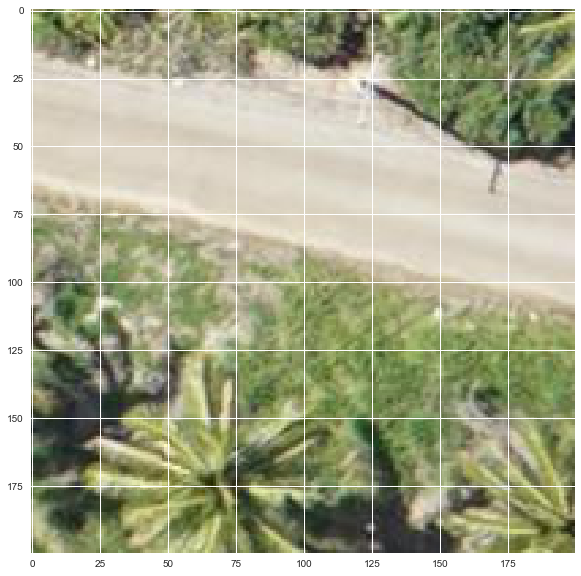

2905 10171
100


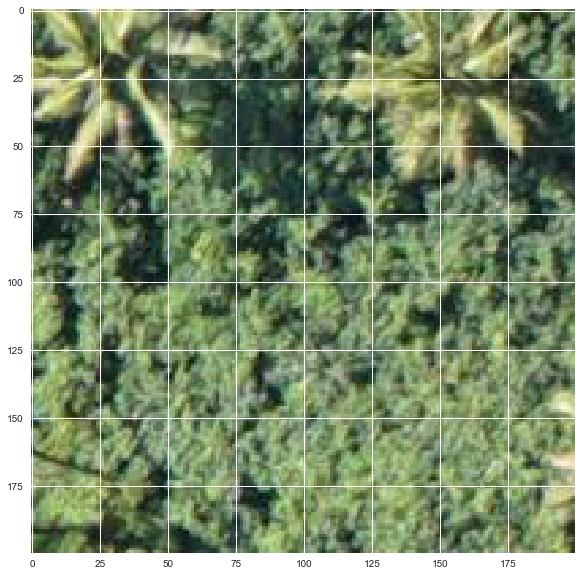

11513 20670
100


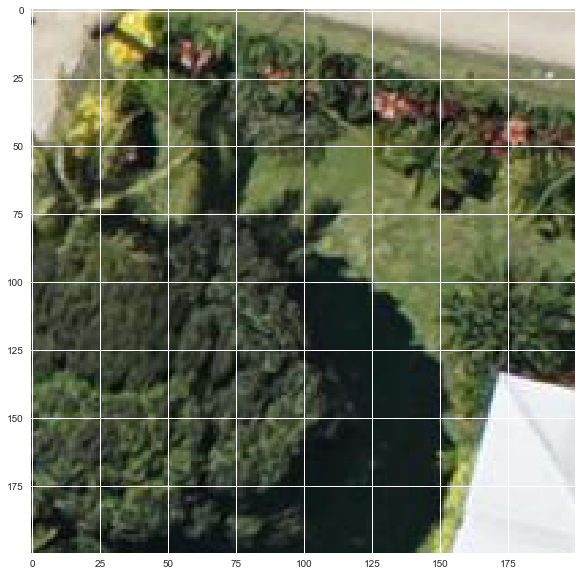

6795 19758
100


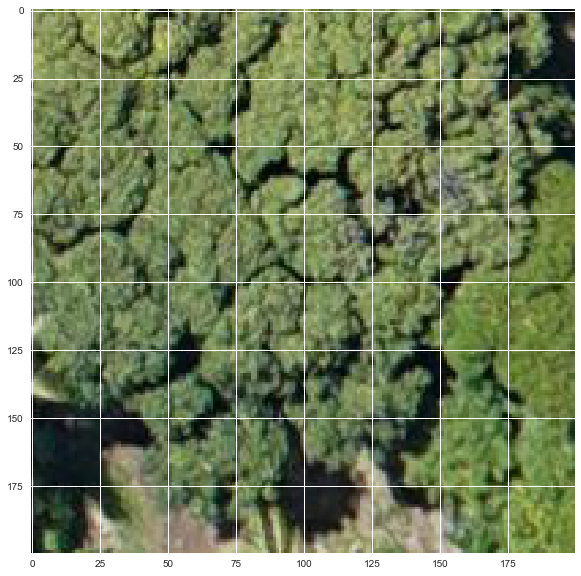

6612 18366
100


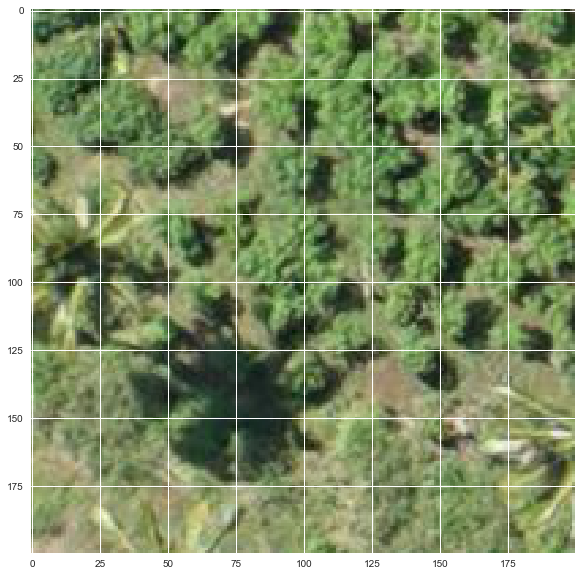

2726 6812
100


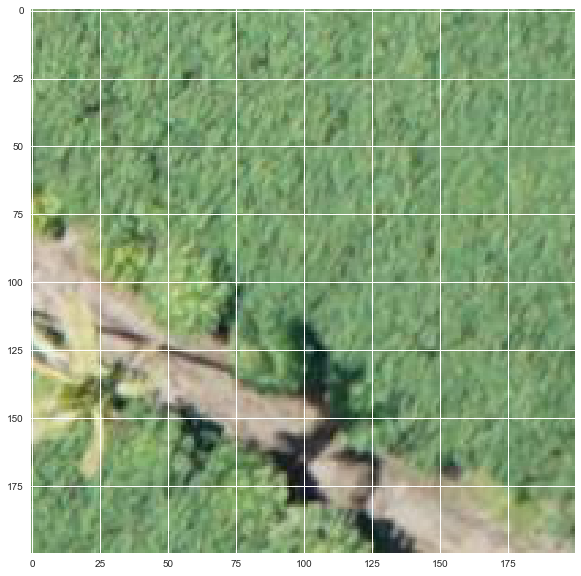

7117 18711
100


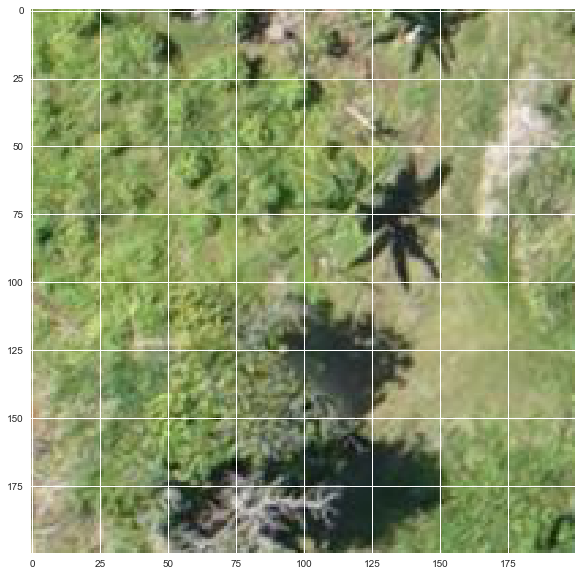

8433 24115
100


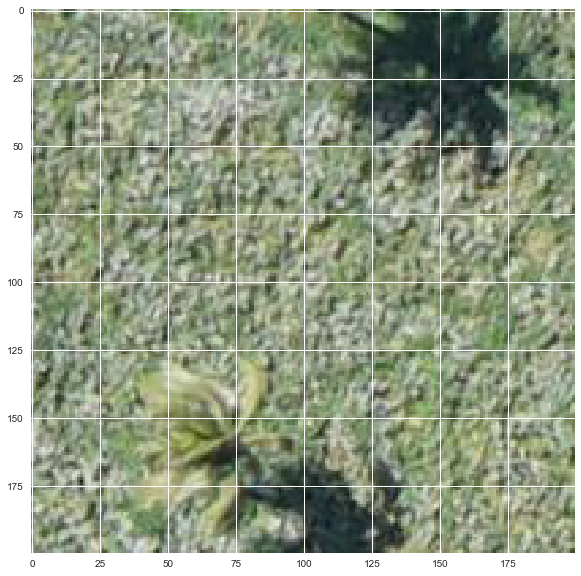

2164 24450
100


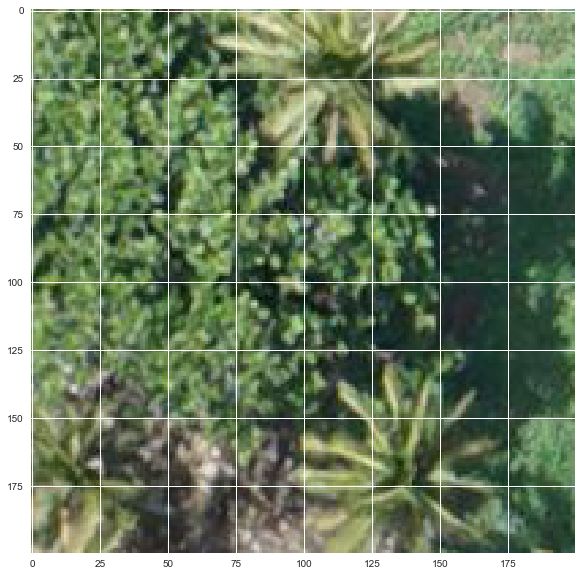

2908 20566
100


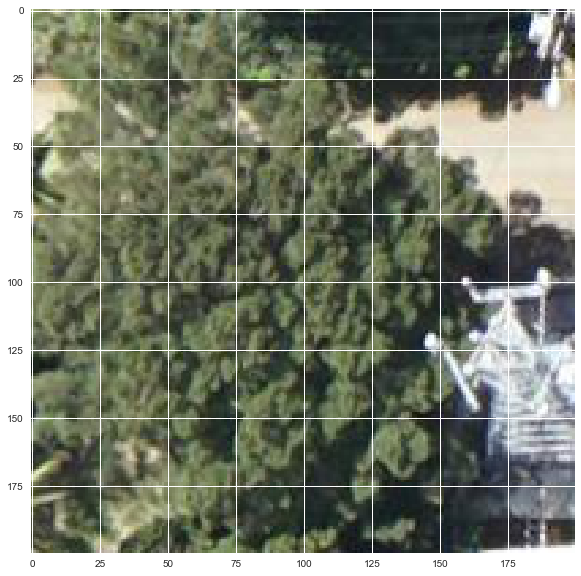

13575 12681
100


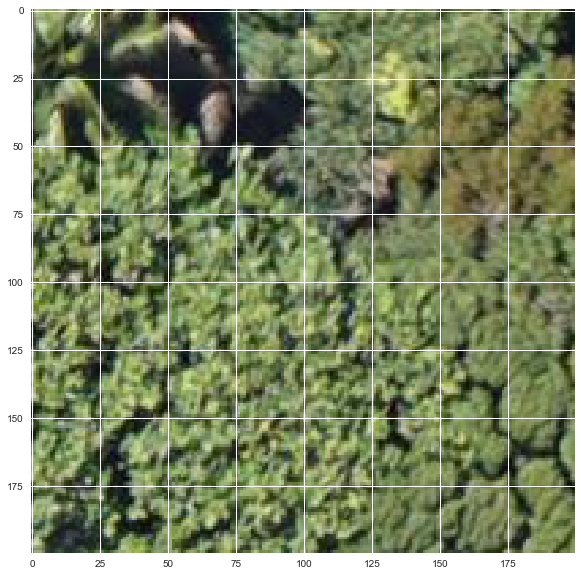

In [8]:
loc_converter = Converter((xgeo0, ygeo0), (xgeoN, ygeoN), img.shape[:2])
handle_image = ImageChunker(img, img.shape[:2])

for index, row in coco_tree.sample(15).iterrows():
    display_segment(loc_converter, handle_image, (row['x'], row['y']))